# Scoring Segmentation

Segment an image with corresponding ground truth and score different network performances

In [42]:
import napari
import cellpose
import octopuslite
from octopuslite import tile
from tqdm.auto import tqdm
import numpy as np
import datetime 
from skimage.io import imsave, imshow, imread
from skimage.measure import label, regionprops
import skimage as ski
from skimage.morphology import remove_small_objects, remove_small_holes, binary_erosion
import os
import itertools, os
from tqdm.auto import tqdm
import scipy.ndimage as ndi

!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img):
    masks, flows, styles, diams = model.eval(img, diameter=250, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Jan 11 10:59:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 49%   79C    P2   298W / 300W |  45013MiB / 49140MiB |    100%      Default |
|                               |                      |                  N/A |
+

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = octopuslite.utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout_df = octopuslite.utils.read_harmony_metadata(metadata_path, assay_layout=True)
octopuslite.utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Load ground truth-image pairs

In [6]:
### quick PREDICTED model output
pred, flows, styles, diams = model.eval(img, diameter=250, channels=[0,0],)     

#### Tidy up ground truth by removing small objects, closing holes and creating unique labels

In [62]:
true = imread('/mnt/DATA/macrohet/segmentation/training/ground_truth/r03c04f*p01-ch99sk38fk1fl1.tiff_2023_01_10-05:48:17_pm.tiff')#.astype(np.uint16)
### unique labels
true = label(true)
true = remove_small_objects(true, min_size=10000)
### need to iterate over each individual segment and erode
new_mask = np.zeros(true.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(true))):
    segment = true == segment_ID 
    eroded_segment = binary_erosion(segment)
    new_mask += eroded_segment.astype(np.uint8)
true = remove_small_holes(new_mask).astype(np.uint8)

  0%|          | 0/1072 [00:00<?, ?it/s]

In [65]:
napari.Viewer().add_image(test)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'test' at 0x7f55a27eb250>

In [70]:
pred = remove_small_objects(pred, min_size=10000)
### need to iterate over each individual segment and erode
new_mask = np.zeros(pred.shape, dtype = np.uint8)
for segment_ID in tqdm(range(1, np.max(pred))):
    segment = pred == segment_ID 
    eroded_segment = binary_erosion(segment)
    new_mask += eroded_segment.astype(np.uint8)
pred = remove_small_holes(new_mask).astype(np.uint8)

  0%|          | 0/463 [00:00<?, ?it/s]

### Conduct segmentation scoring

In [73]:
import sys
sys.path.append('../../unet_segmentation_metrics/')
import umetrics

In [74]:
result = umetrics.calculate(true, pred)

In [80]:
print(result.results)     

 Segmentation Metrics (n=1)
n_true_labels: 624
n_pred_labels: 508
n_true_positives: 299
n_false_positives: 196
n_false_negatives: 68
IoU: 0.989
Jaccard: 0.531
pixel_identity: 0.886
localization_error: 77.205



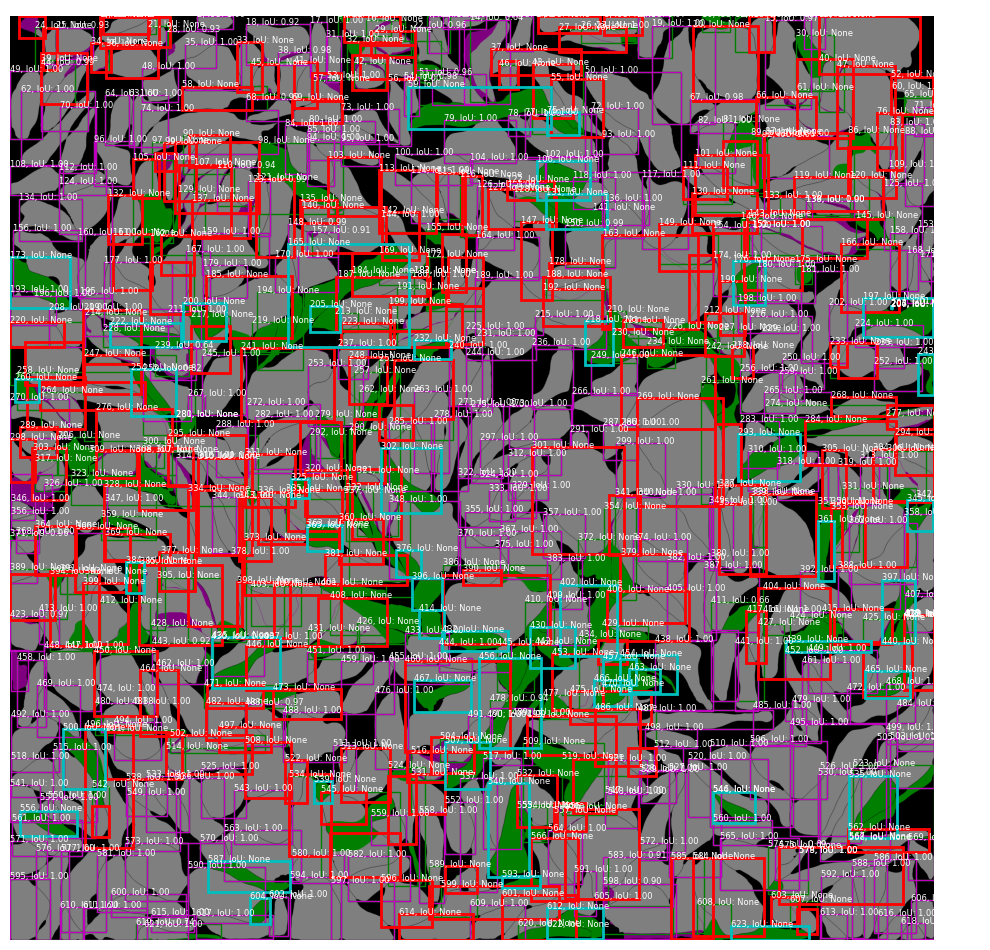

In [76]:
result.plot()

In [38]:
import napari
v = napari.Viewer()

v.add_image(result.image_overlay)
v.add_image(true)
v.add_image(pred)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'pred' at 0x7f96efe99490>